

# **Member**
*   林家誠, 109306066, MIS
*   陳彥竹, 1093060xx, MIS



# **Title**
**url之分析...**

# **Problem Definition**
**Problem Definition**

# **Dataset**
**Dataset**
**介紹**



# **description of your models**
**models**
**介紹**



# **result**
**介紹**



# **discussion**
**介紹**


# 程式碼

## 安裝套件

In [1]:
!pip install transformers
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 下載和解壓檔案

In [2]:
import requests
import zipfile

url = 'https://github.com/Tonyrj3268/DS4CS-FinalProject/raw/main/archive.zip'
response = requests.get(url)
with open('archive.zip', 'wb') as file:
    file.write(response.content)
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

## 加載模組

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import string
from urllib.parse import urlparse
import re
from transformers import BertModel, BertTokenizer
import torch
from imblearn.under_sampling import RandomUnderSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## gpu check

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


## 分析資料集

In [5]:
df = pd.read_csv('/content/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


由於資料集的label分配不均，且資料太過龐大(65萬筆)，使用欠採樣平衡數據集並且縮小訓練資料量，display = True僅供助教和展示時使用(限縮資料量成1萬筆)，原本呈現之結果為欠採樣後之訓練數量。


In [6]:
display = False

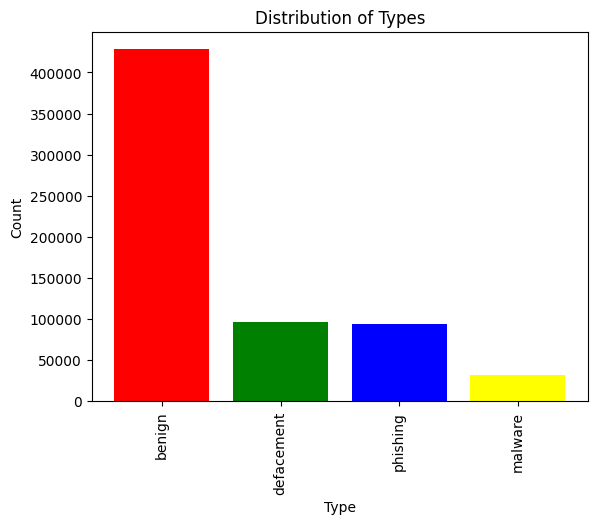

In [7]:
category_counts = df['type'].value_counts()
colors = ['red', 'green', 'blue', 'yellow']
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.xlabel("Type")
plt.ylabel("Count")
plt.title("Distribution of Types")
plt.xticks(rotation='vertical')
plt.show()

In [8]:
X = df[['url']]
y = df['type'] 

under_sampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

print("處理後的樣本數:", len(X_resampled))
print("處理後的樣本分佈:")
print(y_resampled.value_counts())

re_df = pd.concat([X_resampled, y_resampled], axis=1)
if display:
  re_df = re_df.sample(n=10000, random_state=42)

處理後的樣本數: 130080
處理後的樣本分佈:
benign        32520
defacement    32520
malware       32520
phishing      32520
Name: type, dtype: int64


# 預處理

## 特殊字符
計算特殊字符之數量，若完全沒該字符出現，則捨棄此字符欄位。

In [9]:
special_chars = ['!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '-', '+', '=',\
         '{', '}', '[', ']', '|', '\\', ':', ';', '<', '>', ',', '.', '?', '/', '`', '~']  # 定义特殊字符列表

for a in special_chars:
    re_df[a] = re_df['url'].apply(lambda i: i.count(a))
absent_chars = [char for char in special_chars if re_df[char].sum() == 0]
re_df.drop(columns=absent_chars, inplace=True)

## https 檢查 & url長度計算
檢查是否帶有https字串，如有則計為1。  
計算url之總長度

In [10]:
def httpSecure(url):
    http = urlparse(url).scheme
    match = str(http)
    if match=='https':
        return 1
    else:
        return 0
re_df['https'] = re_df['url'].apply(lambda i: httpSecure(i))
re_df['url_len'] = re_df['url'].apply(lambda i: len(str(i)))

In [11]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130080 entries, 0 to 130079
Data columns (total 34 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   url      130080 non-null  object
 1   type     130080 non-null  object
 2   !        130080 non-null  int64 
 3   @        130080 non-null  int64 
 4   #        130080 non-null  int64 
 5   $        130080 non-null  int64 
 6   %        130080 non-null  int64 
 7   ^        130080 non-null  int64 
 8   &        130080 non-null  int64 
 9   *        130080 non-null  int64 
 10  (        130080 non-null  int64 
 11  )        130080 non-null  int64 
 12  _        130080 non-null  int64 
 13  -        130080 non-null  int64 
 14  +        130080 non-null  int64 
 15  =        130080 non-null  int64 
 16  {        130080 non-null  int64 
 17  }        130080 non-null  int64 
 18  [        130080 non-null  int64 
 19  ]        130080 non-null  int64 
 20  |        130080 non-null  int64 
 21  \        1

## 加載bert模型

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 切割url
1.  將url的特殊字符去除，獲得剩餘單字詞的集合，例如:www.example.com => [www, example, com]。
2.  使用已訓練好的tokenizer獲得單詞之token ID，將token集合放入bert 模型生成1維768長度的值
3.  display mode預估訓練時間3分半

In [13]:
def urlSplitBatch(urls):
    url_parts = [re.sub(r'\s+', ' ', re.sub(r'[^\w\s]', ' ', url)).split(' ') for url in urls]
    tokens = [tokenizer.batch_encode_plus(parts, padding=True, truncation=True, return_tensors='pt') for parts in url_parts]
    input_ids = [token["input_ids"] for token in tokens]
    url_vectors = []
    for ids in input_ids:
      with torch.no_grad():
          ids = ids.to(device)
          last_hidden_states = model(ids)[0]
      url_vectors.append(last_hidden_states.mean(dim=[0, 1]).unsqueeze(0))

    url_vectors = torch.cat(url_vectors, dim=0).to(device)
    return url_vectors


# 在主要迴圈中使用批次處理
BATCH_SIZE = 100  # 你可以根據你的硬體配置和需求來調整批次的大小
word_vector = []
rows_to_drop = []
total = len(re_df['url'])
checkpoint = total // 100
for i in range(0, total, BATCH_SIZE):
  batch = re_df['url'][i:i+BATCH_SIZE]
  try:
    split_urls = urlSplitBatch(batch)  # 對整個批次進行split操作
  except:
    print(f"第{i}批資料集發生錯誤，跳過並移除")
    rows_to_drop.extend(range(i, min(i+BATCH_SIZE, len(re_df['url']))))  # 若split操作失敗，將整個批次的索引加入要刪除的列表
    continue

  list_from_tensor = split_urls.tolist()
  word_vector.extend(list_from_tensor)

  if (i + BATCH_SIZE) % checkpoint == 0:
      print("已完成：{:.0f}%".format((i + BATCH_SIZE) / len(re_df['url']) * 100))

已完成：1%
已完成：2%
已完成：3%
已完成：4%
已完成：5%
已完成：6%
已完成：7%
已完成：8%
已完成：9%
已完成：10%
已完成：11%
已完成：12%
已完成：13%
已完成：14%
已完成：15%
已完成：16%
已完成：17%
已完成：18%
已完成：19%
已完成：20%
已完成：21%
已完成：22%
已完成：23%
已完成：24%
已完成：25%
已完成：26%
已完成：27%
已完成：28%
已完成：29%
已完成：30%
已完成：31%
已完成：32%
已完成：33%
已完成：34%
已完成：35%
已完成：36%
已完成：37%
已完成：38%
已完成：39%
已完成：40%
已完成：41%
已完成：42%
已完成：43%
已完成：44%
已完成：45%
已完成：46%
已完成：47%
已完成：48%
已完成：49%
已完成：50%
已完成：51%
已完成：52%
已完成：53%
已完成：54%
已完成：55%
已完成：56%
已完成：57%
已完成：58%
已完成：59%
已完成：60%
已完成：61%
已完成：62%
已完成：63%
已完成：64%
已完成：65%
已完成：66%
已完成：67%
已完成：68%
已完成：69%
已完成：70%
已完成：71%
已完成：72%
已完成：73%
已完成：74%
已完成：75%
已完成：76%
已完成：77%
已完成：78%
已完成：79%
已完成：80%
已完成：81%
已完成：82%
已完成：83%
已完成：84%
已完成：85%
已完成：86%
已完成：87%
已完成：88%
已完成：89%
已完成：90%
已完成：91%
已完成：92%
已完成：93%
已完成：94%
已完成：95%
已完成：96%
已完成：97%
已完成：98%
已完成：99%
已完成：100%


## 切分成3種特徵
1.  純單字詞矩陣
2.  純原url之特徵矩陣
3.  上面兩種之結合

In [14]:
word_vector_array = word_vector
feature_array = re_df.drop(['url', 'type'], axis=1).to_numpy()
merged_array = np.hstack((feature_array, word_vector_array))

target = pd.get_dummies(re_df['type'], columns=['type'])

## scikit-learn 模型訓練
使用決策樹和隨機森林分別對3種特徵進行訓練

In [15]:
feature_arrays = [feature_array, word_vector_array, merged_array]
feature_name = ["feature_array", "word_vector_array", "merged_array"]
models = [DecisionTreeClassifier(), RandomForestClassifier(),XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')]

print("{:<20s} {:<20s} {:<10s}".format("特徵", "模型", "準確率"))
print("="*50)

for i,features in enumerate(feature_arrays):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    for model in models:
        classifier = model

        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)

        accuracy = classifier.score(X_test, y_test)

        print("{:<20s} {:<20s} {:.4f}".format(feature_name[i], model.__class__.__name__, accuracy))

print("="*50)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


特徵                   模型                   準確率       
feature_array        DecisionTreeClassifier 0.8672
feature_array        RandomForestClassifier 0.8835
feature_array        XGBClassifier        0.8607
word_vector_array    DecisionTreeClassifier 0.7297
word_vector_array    RandomForestClassifier 0.7304
word_vector_array    XGBClassifier        0.8218
merged_array         DecisionTreeClassifier 0.8737
merged_array         RandomForestClassifier 0.8428
merged_array         XGBClassifier        0.9145


## 神經網路
使用神經網路對三種資料集進行訓練

In [16]:
class FeatureNet(nn.Module):
    def __init__(self, x_len):
        super(FeatureNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.log_softmax(self.fc3(x), dim=1)
        return x
class WordNet(nn.Module):
    def __init__(self, x_len):
        super(WordNet, self).__init__()
        self.fc1 = nn.Linear(x_len, 600)
        self.bn1 = nn.BatchNorm1d(600)
        self.fc2 = nn.Linear(600, 400)
        self.bn2 = nn.BatchNorm1d(400)
        self.fc3 = nn.Linear(400, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 100)
        self.dropout = nn.Dropout(0.5)
        self.fc5 = nn.Linear(100, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = torch.log_softmax(self.fc5(x), dim=1)  # 使用 LogSoftmax
        return x

In [17]:
mymodels = [FeatureNet(len(feature_array[0])), WordNet(len(word_vector_array[0])), WordNet(len(merged_array[0]))]
feature_names = ["Feature Array", "Word Vector Array", "Merged Array"]
Epoch = 10
loss_results = {}
accuracy_results = {}

for model, feature_name, features in zip(mymodels, feature_names, feature_arrays):
  print(f"\nTraining model with: {feature_name}\n")
  features_train, features_test, labels_train, labels_test = train_test_split(features, target.values, test_size=0.2, random_state=42)

  # numpy轉換tensors
  features_train = torch.tensor(features_train, dtype=torch.float32)
  labels_train = torch.tensor(labels_train, dtype=torch.float32)
  features_test = torch.tensor(features_test, dtype=torch.float32)
  labels_test = torch.tensor(labels_test, dtype=torch.float32)

  train_dataset = TensorDataset(features_train, labels_train)
  test_dataset = TensorDataset(features_test, labels_test)

  batch_size = 64
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  net = model.to(device)
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(net.parameters())
  
  losses = []
  accuracies = []

  for epoch in range(Epoch):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.argmax(dim=1).to(device)
      outputs = net(inputs)

      optimizer.zero_grad()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      if (i + 1) % 10 == 0:    # 每10批次打印一次
        print(f'[{feature_name}] Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {running_loss / (i + 1)}')

    avg_loss = running_loss / (i + 1)
    losses.append(avg_loss)

    # Test the model
    net.eval()  # It's important to set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
      for data in test_dataloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.argmax(dim=1).to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f'[{feature_name}] Epoch {epoch + 1}, Accuracy: {accuracy}')

    net.train()  # Reset the model to training mode

  # Save the average loss and accuracy for this feature
  loss_results[feature_name] = losses
  accuracy_results[feature_name] = accuracies

print('Finished Training')


Training model with: Feature Array

[Feature Array] Epoch 1, Batch 10, Average Loss: 1.4617788434028625
[Feature Array] Epoch 1, Batch 20, Average Loss: 1.386341667175293
[Feature Array] Epoch 1, Batch 30, Average Loss: 1.3517879088719686
[Feature Array] Epoch 1, Batch 40, Average Loss: 1.3211530238389968
[Feature Array] Epoch 1, Batch 50, Average Loss: 1.2986296558380126
[Feature Array] Epoch 1, Batch 60, Average Loss: 1.2816159864266714
[Feature Array] Epoch 1, Batch 70, Average Loss: 1.264825095449175
[Feature Array] Epoch 1, Batch 80, Average Loss: 1.2488145858049393
[Feature Array] Epoch 1, Batch 90, Average Loss: 1.2342895719740126
[Feature Array] Epoch 1, Batch 100, Average Loss: 1.2187774789333343
[Feature Array] Epoch 1, Batch 110, Average Loss: 1.2068525948307731
[Feature Array] Epoch 1, Batch 120, Average Loss: 1.1941505332787832
[Feature Array] Epoch 1, Batch 130, Average Loss: 1.1796543162602644
[Feature Array] Epoch 1, Batch 140, Average Loss: 1.167196491786412
[Feature 

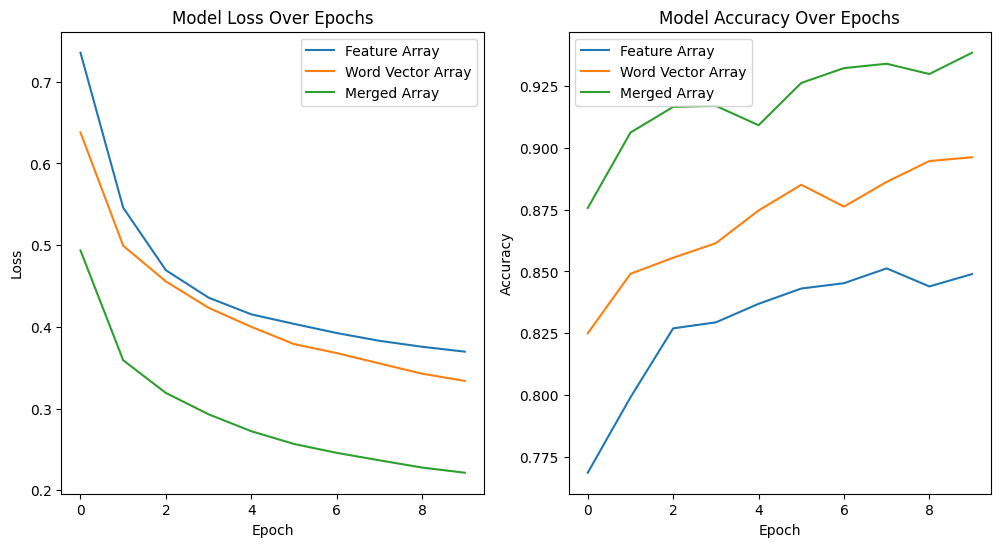

In [18]:
# Draw losses of all features in one graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for feature_name, losses in loss_results.items():
    plt.plot(losses, label=feature_name)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Draw accuracies of all features in one graph
plt.subplot(1, 2, 2)
for feature_name, accuracies in accuracy_results.items():
    plt.plot(accuracies, label=feature_name)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()